In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Data Loading

In [3]:
df = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv',nrows=300000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Shuffling

In [4]:
df=df.sample(frac=1).reset_index(drop=True)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-12-21 13:31:00.00000099,5.3,2010-12-21 13:31:00 UTC,-73.988292,40.754107,-73.993705,40.745993,1
1,2009-10-07 18:40:00.000000190,5.7,2009-10-07 18:40:00 UTC,-73.988930,40.734023,-73.998965,40.730502,1
2,2009-08-07 13:16:25.0000002,7.7,2009-08-07 13:16:25 UTC,-74.000320,40.762313,-73.982991,40.781928,1
3,2015-06-06 21:56:03.0000009,10.5,2015-06-06 21:56:03 UTC,-73.994102,40.754360,-73.981247,40.741573,1
4,2010-10-25 13:50:00.00000012,10.1,2010-10-25 13:50:00 UTC,-73.978672,40.759425,-73.997605,40.766375,2


In [5]:
df.isna().sum()
df=df.dropna()
    

In [6]:
df.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [7]:
#Time is in UTC which is 4 hrs ahead of US Time
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime']) - pd.Timedelta(hours=4)
df['Hour']=df['pickup_datetime'].dt.hour
df['Weekday']=df['pickup_datetime'].dt.strftime("%a")

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Weekday
0,2010-12-21 13:31:00.00000099,5.3,2010-12-21 09:31:00+00:00,-73.988292,40.754107,-73.993705,40.745993,1,9,Tue
1,2009-10-07 18:40:00.000000190,5.7,2009-10-07 14:40:00+00:00,-73.988930,40.734023,-73.998965,40.730502,1,14,Wed
2,2009-08-07 13:16:25.0000002,7.7,2009-08-07 09:16:25+00:00,-74.000320,40.762313,-73.982991,40.781928,1,9,Fri
3,2015-06-06 21:56:03.0000009,10.5,2015-06-06 17:56:03+00:00,-73.994102,40.754360,-73.981247,40.741573,1,17,Sat
4,2010-10-25 13:50:00.00000012,10.1,2010-10-25 09:50:00+00:00,-73.978672,40.759425,-73.997605,40.766375,2,9,Mon


In [8]:
def distance(df,lat,long,lat1,long1):
    radius=6371
    latradians=np.radians(df[lat])
    latradians1=np.radians(df[lat1])
    diflatradians=np.radians(df[lat1]-df[lat])
    diflongradians=np.radians(df[long1]-df[long])
    a=np.sin(diflatradians/2)**2 + np.cos(latradians)* np.sin(diflongradians/2)**2 * np.cos(latradians1)
    distance = radius * (2*np.arctan2(np.sqrt(a),np.sqrt(1-a)))
    return distance

# Distance Between Coordinates

In [9]:
df['distance']=distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [10]:
df['distance'].describe()

count    299998.000000
mean         19.093012
std         363.136869
min           0.000000
25%           1.215327
50%           2.120239
75%           3.886547
max       10942.515639
Name: distance, dtype: float64

In [11]:
df['Am-Pm']='am'
df['Am-Pm'][df['Hour']>=12]='pm'
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Weekday,distance,Am-Pm
0,2010-12-21 13:31:00.00000099,5.3,2010-12-21 09:31:00+00:00,-73.988292,40.754107,-73.993705,40.745993,1,9,Tue,1.010912,am
1,2009-10-07 18:40:00.000000190,5.7,2009-10-07 14:40:00+00:00,-73.988930,40.734023,-73.998965,40.730502,1,14,Wed,0.931792,pm
2,2009-08-07 13:16:25.0000002,7.7,2009-08-07 09:16:25+00:00,-74.000320,40.762313,-73.982991,40.781928,1,9,Fri,2.624233,am
3,2015-06-06 21:56:03.0000009,10.5,2015-06-06 17:56:03+00:00,-73.994102,40.754360,-73.981247,40.741573,1,17,Sat,1.787286,pm
4,2010-10-25 13:50:00.00000012,10.1,2010-10-25 09:50:00+00:00,-73.978672,40.759425,-73.997605,40.766375,2,9,Mon,1.771959,am


# Data Understanding

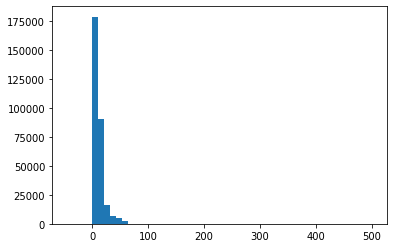

In [12]:
plt.hist(df['fare_amount'],bins=50)
plt.show()
#Most of the fare_amounts are less than 75 dollars

In [13]:
df1=df[(df['fare_amount']>=0)  ]
df=df[(df['fare_amount']>=0)  ]
# Some instances where fare_amount is less than 0

df1.shape

(299983, 12)

In [14]:
col=['Hour','Weekday','Am-Pm','fare_amount']
col1=col[:-1]
df1=df1[col]
df1.head()
print(col1)

['Hour', 'Weekday', 'Am-Pm']


# Categorical Variables Identified

    Hour_avg_fare_amount
0                  13.55
1                  15.19
2                  12.29
3                  10.98
4                  10.86
5                  10.81
6                  10.82
7                  11.19
8                  11.13
9                  11.71
10                 11.84
11                 12.06
12                 11.96
13                 11.29
14                 10.99
15                 10.67
16                 10.83
17                 11.01
18                 11.31
19                 11.57
20                 11.79
21                 11.48
22                 11.60
23                 12.05
     Weekday_avg_fare_amount
Fri                    11.38
Mon                    11.42
Sat                    10.97
Sun                    11.80
Thu                    11.56
Tue                    11.22
Wed                    11.29
    Am-Pm_avg_fare_amount
am                  11.47
pm                  11.26


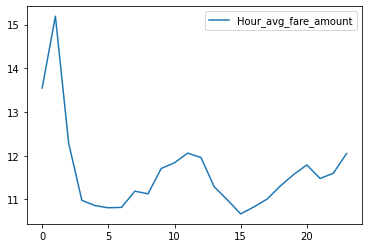

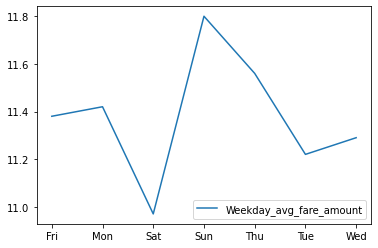

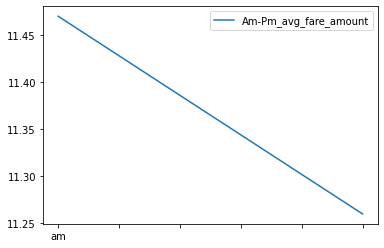

In [15]:
for i in col1:
    ls1=[]
    ls2=[]
    for j in sorted(df1[i].unique()):
        a=df1[df1[i]==j]["fare_amount"].mean(axis=0)
        ls1.append(round(a,2))
        ls2.append(j)
    ls=pd.DataFrame(data = ls1, 
                  index = ls2, 
                  columns = [i+"_avg_fare_amount"])
    ls.plot()
    print(ls)

In [16]:
cat_col=["Hour","Weekday","Am-Pm"]
con_col=['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance','passenger_count' ]
df_cat=df[cat_col]
df_con=df[con_col]
y_col = ['fare_amount']

In [17]:
#to convert the type to category
for cat in df_cat.columns:
    df_cat[cat] = df_cat[cat].astype('category')

df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299983 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   Hour     299983 non-null  category
 1   Weekday  299983 non-null  category
 2   Am-Pm    299983 non-null  category
dtypes: category(3)
memory usage: 3.1 MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
cat=np.stack([df_cat[i].cat.codes.values for i in df_cat.columns ],1)
cat[:5]
cat = torch.tensor(cat, dtype=torch.int64)

In [19]:
con=np.stack([df_con[i].values for i in df_con.columns],1)
con[:5]
con = torch.Tensor(con)
print(con.dtype)

torch.float32


In [20]:
y=torch.Tensor(np.stack([df[y_col].values],1)).reshape(-1,1)
print(y.dtype)


torch.float32


In [21]:
#Embeddings for Categorical Variables
embcat=[(df_cat[i].nunique(),(df_cat[i].nunique()+1)//2) for i in df_cat.columns]
print(embcat)

[(24, 12), (7, 4), (2, 1)]


# NN Model with Fexible Layers

In [22]:
#Dropout is used so as to to reduce over fitting
class Tabular1(nn.Module):
    def __init__(self,con_n,out_sz,layers,embcat,p=0.5):
        super().__init__()
        layerlist=[]
        self.drop=nn.Dropout(p)
        self.emb=nn.ModuleList([nn.Embedding(i,o) for (i,o) in embcat])
        self.cont=nn.BatchNorm1d(con_n)
        total_cat=sum([o for (i,o) in embcat])
        totaln=total_cat+con_n
        for i in layers:
            layerlist.append(nn.Linear(totaln,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            totaln=i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers=nn.Sequential(*layerlist)
    def forward(self,xcat,xcon):
        embe=[]
        for i, e in enumerate(self.emb):
            embe.append(e(xcat[:,i]))
        xcat=torch.cat(embe,1)
        xcat=self.drop(xcat)
        xcon=self.cont(xcon)
        x=torch.cat([xcat,xcon],1)
        x=self.layers(x)
        return x

In [23]:
model=Tabular1(con.shape[1],1,[200,100],embcat,0.4)

In [24]:
model

Tabular1(
  (drop): Dropout(p=0.4, inplace=False)
  (emb): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(7, 4)
    (2): Embedding(2, 1)
  )
  (cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [25]:
#number of parameters
total=0
for param in model.parameters():
    print(param.numel())
    total+=param.numel()
print(f'Total: {total}')    

288
28
2
6
6
4600
200
200
200
20000
100
100
100
100
1
Total: 25931


In [26]:
criteria=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
#to get batches
cat_con=torch.cat([cat,con],1)
print(cat_con.shape)
train_size=int(cat_con.shape[0]*0.8)
cat_con_tr=cat_con[:train_size]
cat_con_te=cat_con[train_size:]
X_cat_tr=cat_con_tr[:,:len(df_cat.columns)]
X_cat_tr=X_cat_tr.type(torch.long)
X_cat_te=cat_con_te[:,:len(df_cat.columns)]
X_con_tr=cat_con_tr[:,len(df_cat.columns):]
X_cat_te=X_cat_te.type(torch.long)
X_con_te=cat_con_te[:,len(df_cat.columns):]
ytr=y[:train_size]
yte=y[train_size:]
print(cat_con_te.shape)
print(X_cat_tr.dtype)
print(ytr.shape)
print(X_cat_tr.shape)

torch.Size([299983, 9])
torch.Size([59997, 9])
torch.int64
torch.Size([239986, 1])
torch.Size([239986, 3])


# Creating Batches

In [28]:
train=TensorDataset(cat_con_tr,ytr)
print(train[0])
#creating batches for training 
train_data=DataLoader(train,batch_size=10000,shuffle=True)

(tensor([  9.0000,   5.0000,   0.0000, -73.9883,  40.7541, -73.9937,  40.7460,
          1.0109,   1.0000]), tensor([5.3000]))


# Training

In [29]:
import time
start=time.time()
epochs=300
losses1=[]
val_losses=[]
for i in range (epochs):
    i=i+1
    for b,(X_train,y_train) in enumerate(train_data):
        X_train_cat=X_train[:,:len(df_cat.columns)]
        X_train_cat = X_train_cat.type(torch.LongTensor)
        X_train_con=X_train[:,len(df_cat.columns):]
        y_pred = model(X_train_cat, X_train_con)
        loss = torch.sqrt(criteria(y_pred, y_train))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    y_pred = model(X_cat_tr,X_con_tr)
    loss = torch.sqrt(criteria(y_pred, ytr))
    if i%10==0:
        print(f'Epoch:{i} Loss:{loss.item():10.4f}')
    losses1.append(loss.item()) 
    with torch.no_grad():
        y_val = model(X_cat_te,X_con_te)
        loss = torch.sqrt(criteria(y_val,yte))
        val_losses.append(loss.item()) 
print(f'Time in mins: {((time.time()-start)/60):10.4f}')        

Epoch:10 Loss:   10.2760
Epoch:20 Loss:    6.6365
Epoch:30 Loss:    6.2017
Epoch:40 Loss:    6.1042
Epoch:50 Loss:    5.9342
Epoch:60 Loss:    5.9007
Epoch:70 Loss:    5.8668
Epoch:80 Loss:    5.8844
Epoch:90 Loss:    5.8020
Epoch:100 Loss:    5.7807
Epoch:110 Loss:    5.7492
Epoch:120 Loss:    5.7649
Epoch:130 Loss:    5.7110
Epoch:140 Loss:    5.7251
Epoch:150 Loss:    5.6957
Epoch:160 Loss:    5.8131
Epoch:170 Loss:    5.7345
Epoch:180 Loss:    5.7457
Epoch:190 Loss:    5.7628
Epoch:200 Loss:    5.6696
Epoch:210 Loss:    5.6699
Epoch:220 Loss:    5.6519
Epoch:230 Loss:    5.6630
Epoch:240 Loss:    5.6530
Epoch:250 Loss:    5.6675
Epoch:260 Loss:    5.6233
Epoch:270 Loss:    5.6609
Epoch:280 Loss:    5.6311
Epoch:290 Loss:    5.6198
Epoch:300 Loss:    5.6259
Time in mins:    65.9528


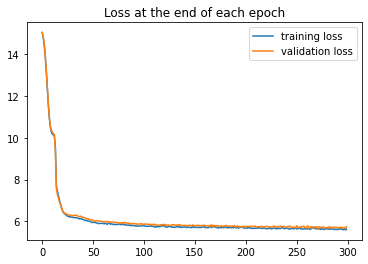

In [30]:
plt.plot(losses1, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

# Output of NN

In [31]:
with torch.no_grad():
    y_val = model(X_cat_te,X_con_te)
    loss = torch.sqrt(criteria(y_val,yte))
print(f'RMSE: {loss:.8f}')

RMSE: 5.66913080


Training for more Epochs and for more Layers can be looked into. Feel free to make changes to the code and get better models.